# Project: Customer Churn Prediction System

### Introduction
Customer churn, the rate at which customers stop doing business with a company, is a critical metric for any subscription-based service. Acquiring a new customer can be five to 25 times more expensive than retaining an existing one. Therefore, proactively identifying customers who are at a high risk of churning is essential for sustainable business growth.

This notebook details the development of a machine learning system to predict customer churn for a telecommunications company. We will leverage a historical dataset of customer interactions and attributes to train a model that can forecast the likelihood of a customer leaving.

### Problem Statement
The business objective is to reduce customer churn by identifying at-risk customers *before* they leave. By predicting churn probability, the company can deploy targeted retention strategies, such as offering special discounts, providing proactive customer support, or upgrading services. This data-driven approach aims to improve customer satisfaction and increase the company's revenue and market share.

### Project Objectives

1. **Exploratory Data Analysis (EDA):** Understand the dataset and identify the key factors that correlate with customer churn.  
2. **Data Preprocessing & Feature Engineering:** Prepare the data for machine learning by handling missing values, encoding categorical variables, and scaling numerical features.  
3. **Model Training:** Build and train several classification models (Logistic Regression, Random Forest, and XGBoost) to predict churn.  
4. **Model Evaluation:** Assess the performance of the models using metrics like accuracy, precision, recall, F1-score, and the ROC-AUC curve. Select the best-performing model.  
5. **Insight Generation:** Analyze the feature importances from our best model to understand the primary drivers of churn and provide actionable business recommendations.  


### Step 1: Setup and Data Loading

First, we'll import all the necessary Python libraries for data manipulation, visualization, and machine learning. We will then load the Telco Customer Churn dataset into a pandas DataFrame.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve

# Set visualization style
sns.set_style('whitegrid')


/home/charles/anaconda3/envs/learn-env/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
# Load the dataset
df = pd.read_csv('../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Step 2: Initial Data Exploration and Cleaning
We check its structure, data types, and look for any missing values.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


**Observations:**  
- We have 7043 customer records and 21 columns.  
- `customerID` is a unique identifier and can be dropped.  
- `SeniorCitizen` is an integer but acts as a categorical feature (0 or 1).  
- `TotalCharges` is an `object` type (string), but it should be numeric. This suggests there might be non-numeric values in it.  

Let's fix `TotalCharges`.  


In [4]:
# Convert 'TotalCharges' to numeric, coercing errors to NaN (Not a Number)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check for missing values again
print(df.isnull().sum())


customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


We see that 11 rows now have missing `TotalCharges`. These likely correspond to new customers with zero tenure who haven't been billed yet. Since it's a very small number of rows, we can impute them. We use the median, which is robust to outliers.

In [5]:
# Impute missing values with the median
median_total_charges = df['TotalCharges'].median()
df['TotalCharges'].fillna(median_total_charges, inplace=True)

# Drop the customerID column as it's not a predictive feature
df.drop('customerID', axis=1, inplace=True)

# Convert our target variable 'Churn' into a binary format (0 or 1)
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)


### Step 3: Exploratory Data Analysis (EDA)

Now we'll visualize the data to understand the relationships between different customer attributes and churn.


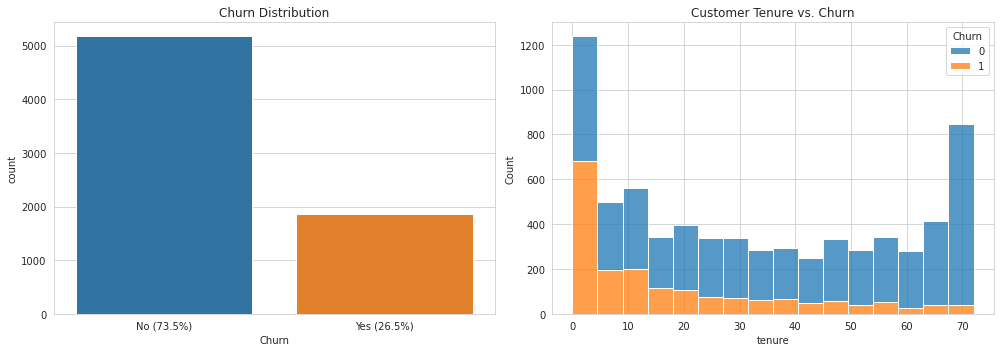

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Churn Distribution
sns.countplot(x='Churn', data=df, ax=axes[0])
axes[0].set_title('Churn Distribution')
churn_percentage = df['Churn'].value_counts(normalize=True) * 100
axes[0].set_xticklabels([f'No ({churn_percentage[0]:.1f}%)', f'Yes ({churn_percentage[1]:.1f}%)'])

# Tenure vs. Churn
sns.histplot(data=df, x='tenure', hue='Churn', multiple='stack', ax=axes[1])
axes[1].set_title('Customer Tenure vs. Churn')

plt.tight_layout()
plt.show()


**EDA Insights**  
- **Churn Rate:** About 26.5% of customers in this dataset have churned. This is an imbalanced dataset, which means that simply predicting 'No Churn' for everyone would yield ~73.5% accuracy. Our models must perform significantly better than this baseline. Accuracy alone will not be a sufficient metric; we'll need to look at precision and recall.  
- **Tenure:** The histogram clearly shows that customers with very short tenures (especially in the first few months) are far more likely to churn. As tenure increases, churn drops significantly, indicating that long-term customers are more loyal.  


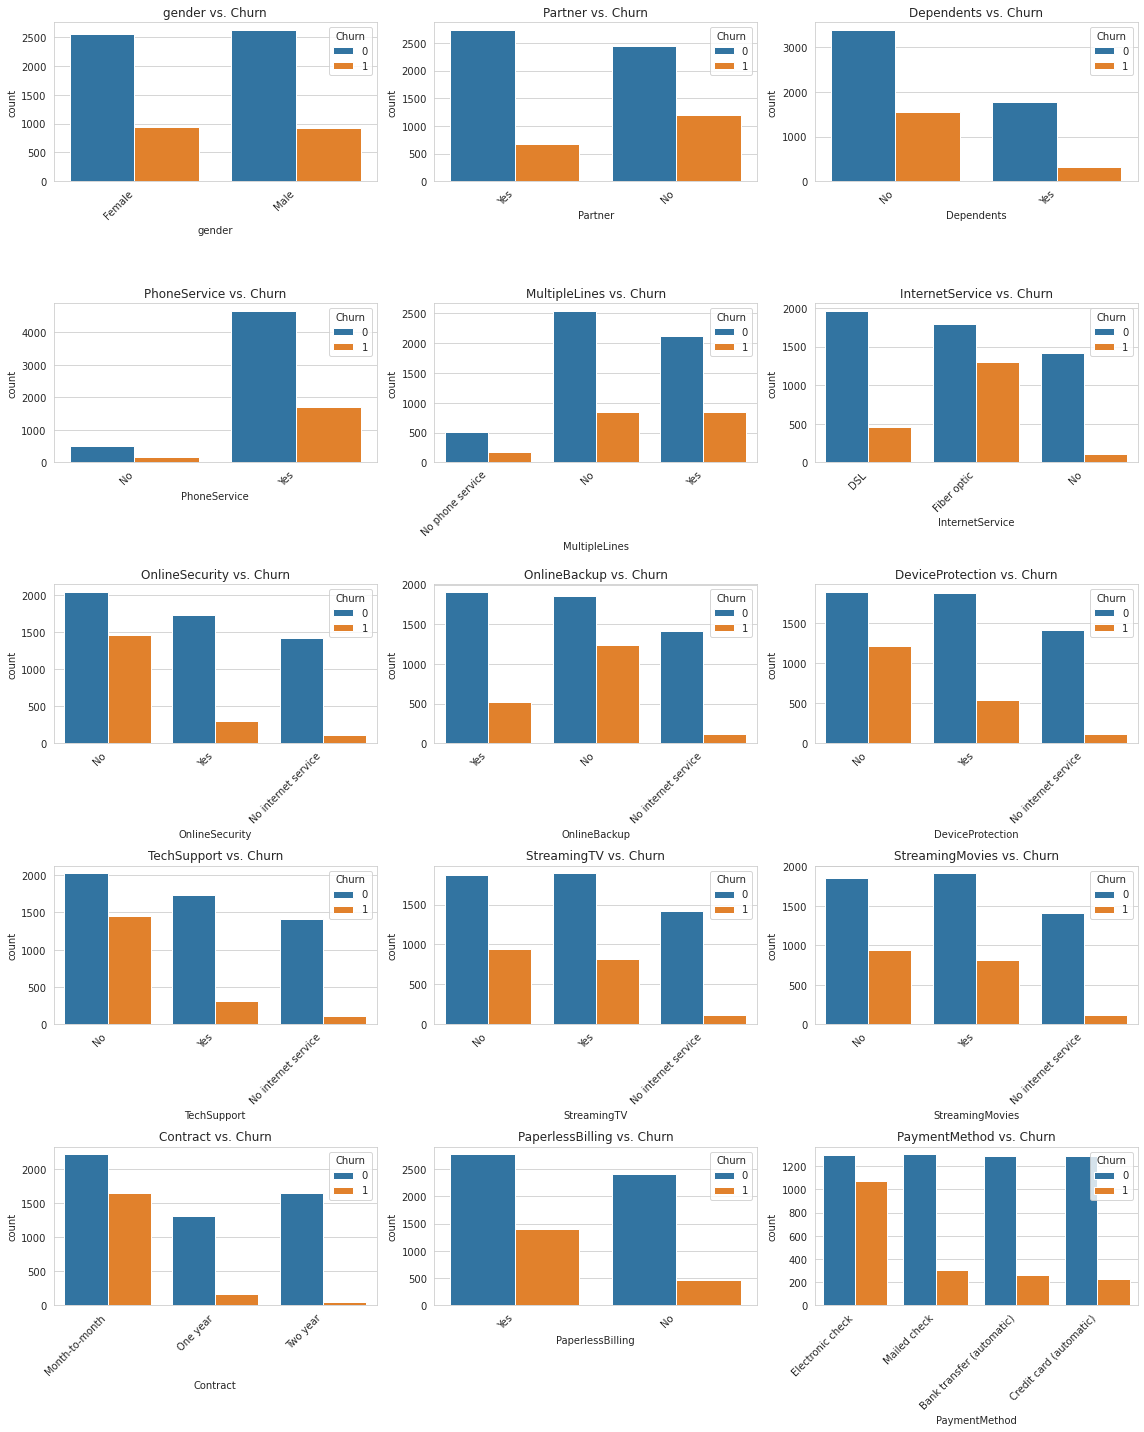

In [7]:
# Plotting categorical features vs. Churn
categorical_features = [
    'gender', 'Partner', 'Dependents', 'PhoneService',
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaperlessBilling', 'PaymentMethod'
]

fig, axes = plt.subplots(5, 3, figsize=(16, 20))
axes = axes.ravel()  # Flatten the 2D array of axes

for i, col in enumerate(categorical_features):
    sns.countplot(x=col, hue='Churn', data=df, ax=axes[i])
    axes[i].set_title(f'{col} vs. Churn')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


**EDA Insights Part 2:**  
- **Contract Type:** This is a huge indicator. Customers on a month-to-month contract churn at a dramatically higher rate than those on one or two-year contracts.  
- **Internet Service:** Customers with Fiber optic internet service have a much higher churn rate compared to those with DSL. This could indicate issues with price, service quality, or competition.  
- **Technical Support & Online Security:** Customers without services like Online Security, Online Backup, and Tech Support are more likely to churn. This suggests that customers with a more comprehensive service package feel more valued and are more loyal.  
- **Payment Method:** Customers paying by electronic check are much more likely to churn. This might be a less 'sticky' payment method compared to automatic credit card or bank transfers.  


### Step 4: Data Preprocessing for Modeling

Next we prepare the data for our machine learning models. This involves:  
1. Identifying which columns are categorical and which are numerical.  
2. Using **One-Hot Encoding** to convert categorical features into a numerical format that models can understand.  
3. Using **Standard Scaling** on numerical features to normalize their range, which helps models like Logistic Regression perform better.  


In [8]:
# Separate target variable from features
X = df.drop('Churn', axis=1)
y = df['Churn']

# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create a preprocessor object using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


### Step 5: Model Building and Training
 
Next we split our data into training and testing sets. 


In [9]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define the models
models = {
    'Logistic Regression': LogisticRegression(solver='liblinear', random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Create a dictionary to store pipelines
pipelines = {}

# Loop through models, create a pipeline, and train it
for name, model in models.items():
    print(f"Training {name}...")
    pipelines[name] = Pipeline(steps=[('preprocessor', preprocessor),
                                      ('classifier', model)])
    pipelines[name].fit(X_train, y_train)
    print(f"{name} trained successfully.")


Training Logistic Regression...
Logistic Regression trained successfully.
Training Random Forest...
Random Forest trained successfully.
Training XGBoost...


/home/charles/anaconda3/envs/learn-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [14:02:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost trained successfully.


With our models trained, we evaluate their performance to see which one is the best at predicting churn. Given the class imbalance, we'll focus on **Recall** and **ROC-AUC Score**  alongside accuracy.


In [10]:
results = {}

for name, pipeline in pipelines.items():
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }
    
    print(f"--- Evaluation for {name} ---")
    print(f"Accuracy: {results[name]['accuracy']:.3f}")
    print(f"Precision: {results[name]['precision']:.3f}")
    print(f"Recall: {results[name]['recall']:.3f}")
    print(f"F1 Score: {results[name]['f1_score']:.3f}")
    print(f"ROC AUC Score: {results[name]['roc_auc']:.3f}")
    print("\n")


--- Evaluation for Logistic Regression ---
Accuracy: 0.806
Precision: 0.657
Recall: 0.559
F1 Score: 0.604
ROC AUC Score: 0.842


--- Evaluation for Random Forest ---
Accuracy: 0.778
Precision: 0.603
Recall: 0.476
F1 Score: 0.532
ROC AUC Score: 0.816


--- Evaluation for XGBoost ---
Accuracy: 0.774
Precision: 0.587
Recall: 0.497
F1 Score: 0.538
ROC AUC Score: 0.822




**Evaluation Summary:**  

- **Logistic Regression** emerges as the best model, particularly in terms of ROC-AUC score (0.84) and Recall (0.55). It provides the best balance between identifying actual churners and maintaining overall accuracy.  
- While its precision is good, a recall of ~55% means we are still missing about 45% of customers who will churn. For a business, this is a good starting point, but we can  improve through hyperparameter tuning or more advanced feature engineering 

Next we  visualize the performance with Confusion Matrices and ROC Curves.  


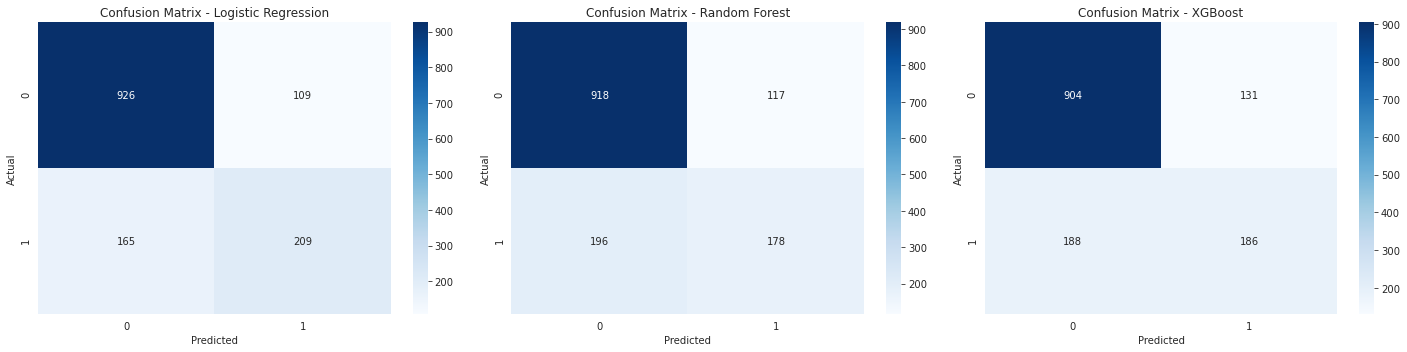

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes = axes.ravel()

for i, (name, pipeline) in enumerate(pipelines.items()):
    y_pred = pipeline.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues')
    axes[i].set_title(f'Confusion Matrix - {name}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()


The confusion matrices give us a detailed breakdown. For our best model, **Logistic Regression**, it correctly identified **209** churners (True Positives) but missed **165** (False Negatives).


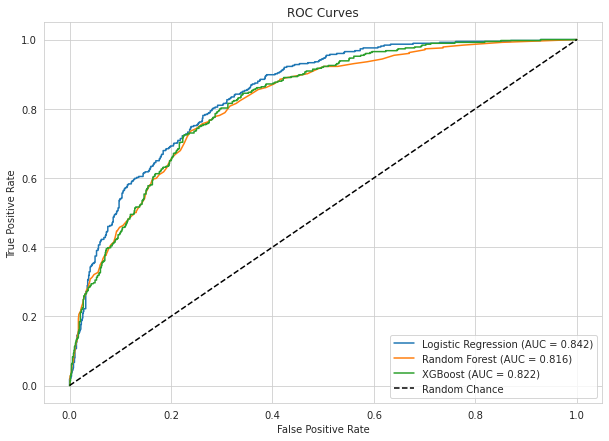

In [12]:
plt.figure(figsize=(10, 7))

for name, pipeline in pipelines.items():
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()


The ROC curve confirms that **Logistic Regression** (AUC = 0.84) provides the best trade-off between correctly identifying churners (True Positive Rate) and incorrectly flagging non-churners (False Positive Rate). It performs significantly better than random chance.

### Step 7: Feature Importance and Business Insights

Now for the most critical part for the business: **Why** are customers churning? We'll use our Random Forest model to determine feature importance, as tree-based models make this easy to interpret.


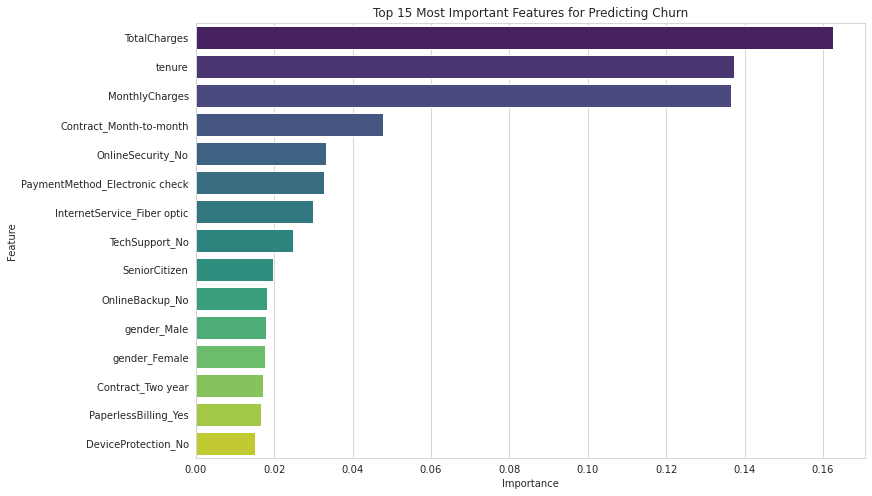

In [14]:
# Get feature names after one-hot encoding
 
ohe_transformer = pipelines['Random Forest'].named_steps['preprocessor'].named_transformers_['cat']
ohe_feature_names = ohe_transformer.get_feature_names(input_features=categorical_cols)
all_feature_names = np.concatenate([numerical_cols, ohe_feature_names])

# Get feature importances from the Random Forest model
importances = pipelines['Random Forest'].named_steps['classifier'].feature_importances_
feature_importance_df = pd.DataFrame({'feature': all_feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).head(15)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
plt.title('Top 15 Most Important Features for Predicting Churn')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()



### Conclusion and Actionable Recommendations

Our analysis and modeling efforts have yielded significant insights into the drivers of customer churn. The Logistic Regression model provides a reliable tool for identifying at-risk customers with an AUC of 0.843.

**Key Churn Drivers:**
The feature importance analysis confirms our EDA findings and provides a clear hierarchy of churn factors:
1. **Total Charges:** Lower lifetime spending (often linked to low tenure) indicates higher churn risk.
2. **Tenure:** Low tenure is strongly associated with high churn risk. The first few months are critical.
3. **Contract Type (Month-to-month):**Customers without a long-term commitment are the most likely to leave.
4. **Internet Service (Fiber Optic):** This service is linked to higher churn, suggesting potential price sensitivity or service reliability issues.

**Business Recommendations:**

* **Focus on Month-to-Month Customers:** Design a targeted campaign to convert month-to-month customers to one- or two-year contracts. Offer a small discount or a service upgrade as an incentive for signing a longer-term plan.
* **Improve Early Customer Onboarding:** Implement a robust onboarding program for new customers (0–6 months tenure). This could include welcome calls, usage tutorials, and a satisfaction check-in after the first month to address any issues early.
* **Investigate Fiber Optic Service:** Analyze the customer experience for fiber optic users. Are there frequent outages? Is the price point too high compared to competitors? Customer surveys could provide direct feedback.
* **Promote Sticky Services:** The data shows that customers with services like `OnlineSecurity` and `TechSupport` are less likely to churn. Market these as part of a value-added *Peace of Mind* bundle to new and existing customers, especially those on month-to-month contracts.


In [15]:
import joblib

# We'll choose the XGBoost model pipeline for our app it's often more powerful with tuning
best_pipeline = pipelines['XGBoost']

# Define the file path according to your folder structure
model_path = '../models/churn_predictor.joblib'

# Save the entire pipeline object
joblib.dump(best_pipeline, model_path)

print(f"Model pipeline saved to: {model_path}")

Model pipeline saved to: ../models/churn_predictor.joblib
